In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install dieboldmariano

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from dieboldmariano import dm_test
from scipy.stats import t

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import pywt
import torch
import glob
import sys
import re
import os

In [ ]:
sys.path.append("/content/drive/MyDrive/WaveletFrequencyDecomposed_CNN_Transformer")
from nearest_correlation import nearcorr
#https://github.com/mikecroucher/nearest_correlation

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WaveletFrequencyDecomposed_CNN_Transformer/data/train_data.csv')
df.set_index('timestamp', inplace=True)

### Wavelet Decomposed Cryptocurrency data

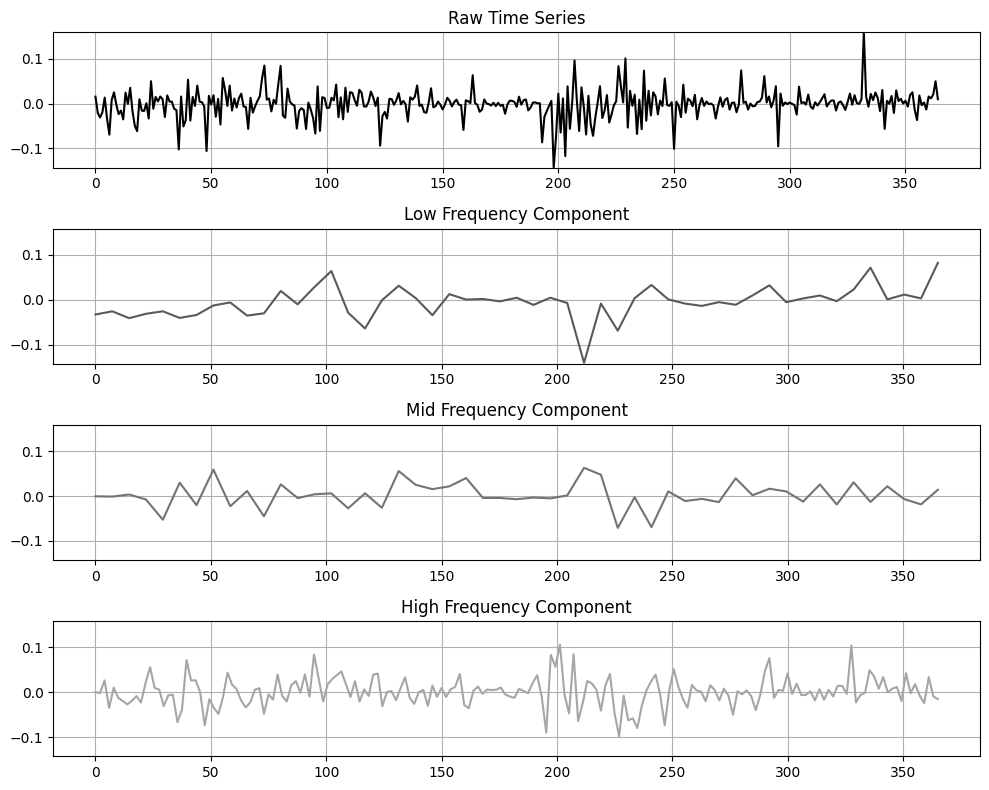

In [ ]:
data = df.values
btc_data = data[:, 0]   # sample
window_size = 365       # 2018.05.05 - 2019.05.04
window_data = btc_data[:window_size]

wavelet='db4'
level=3

coeffs = pywt.wavedec(window_data, wavelet, level=level)
cA3, cD3, _, cD1 = coeffs

times_raw = np.arange(len(window_data))
times_cA3 = np.linspace(0, len(window_data), len(cA3))
times_cD3 = np.linspace(0, len(window_data), len(cD3))
times_cD1 = np.linspace(0, len(window_data), len(cD1))

all_vals = np.concatenate([window_data, cA3, cD3, cD1])
y_min, y_max = all_vals.min(), all_vals.max()

fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharey=True)

axs[0].plot(times_raw, window_data, color='black')
axs[0].set_title('Raw Time Series')
axs[0].grid()

axs[1].plot(times_cA3, cA3, color='0.35')
axs[1].set_title('Low Frequency Component')
axs[1].grid()

axs[2].plot(times_cD3, cD3, color='0.45')
axs[2].set_title('Mid Frequency Component')
axs[2].grid()

axs[3].plot(times_cD1, cD1, color='0.65')
axs[3].set_title('High Frequency Component')
axs[3].grid()

# 동일한 y축 범위 설정
for ax in axs:
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/WaveletFrequencyDecomposed_CNN_Transformer/figure/Wavelet.png')
plt.show()

### Evaluation

In [ ]:
model_save_path = '/content/drive/MyDrive/WaveletFrequencyDecomposed_CNN_Transformer/best_model'

WCT_loaded = torch.load(f"{model_save_path}/best_model_window10per30_WCT_result.pt", map_location=torch.device('cpu'))
WC_loaded = torch.load(f"{model_save_path}/best_model_window10per30_WC_result.pt", map_location=torch.device('cpu'))
WT_loaded = torch.load(f"{model_save_path}/best_model_window10per30_WT2_result.pt", map_location=torch.device('cpu'))
CT_loaded = torch.load(f"{model_save_path}/best_model_window10per30_CT2_result.pt", map_location=torch.device('cpu'))

dcc_dir = "/content/drive/MyDrive/WaveletFrequencyDecomposed_CNN_Transformer/data/forecasting_by_DCC_GARCH_10days_120"

target_tensor = WCT_loaded['targets']
files = sorted(glob.glob(os.path.join(dcc_dir, "correlation_*.csv")))
T, M, N = target_tensor.shape

preds_list = []
for f in files[:T]:
    df = pd.read_csv(f, index_col=0)
    mat = df.values.astype(float)
    preds_list.append(mat)

preds = torch.tensor(np.stack(preds_list, axis=0), dtype=torch.float32)

DCC_GARCH_loaded = {
        "preds": preds,
        "targets": target_tensor[:preds.shape[0]]
    }

In [ ]:
## Original Score

for title, model in zip(['WCT', 'Wavelet Decomposed CNN', 'Wavelet Decomposed Transformer', 'CNN Transformer', 'DCC GARCH'], [WCT_loaded, WC_loaded, WT_loaded, CT_loaded, DCC_GARCH_loaded]):

    preds_tensor = model['preds']
    targets_tensor = model['targets']

    preds_flat = preds_tensor.contiguous().view(preds_tensor.size(0), -1).cpu().numpy()
    targets_flat = targets_tensor.contiguous().view(targets_tensor.size(0), -1).cpu().numpy()

    mse = mean_squared_error(targets_flat, preds_flat)
    mae = mean_absolute_error(targets_flat, preds_flat)
    rmse = np.sqrt(mse)

    # frobenius_loss
    cos_sim = cosine_similarity(targets_flat, preds_flat)
    mean_cos_sim = np.diag(cos_sim).mean()

    # frobenius_loss
    diff = preds_tensor - targets_tensor
    frobenius_per_sample = torch.norm(diff, p='fro', dim=(1, 2))
    mean_frobenius = frobenius_per_sample.mean().item()

    print(f"{title} Evaluation Results:")
    print(f"MSE               : {mse:.5f}")
    print(f"MAE               : {mae:.5f}")
    print(f"RMSE              : {rmse:.5f}")
    print(f"Cosine Similarity : {mean_cos_sim:.5f}")
    print(f"Frobenius Norm    : {mean_frobenius:.5f}")

WCT Evaluation Results:
MSE               : 0.06203
MAE               : 0.17628
RMSE              : 0.24907
Cosine Similarity : 0.94605
Frobenius Norm    : 1.79540
Wavelet Decomposed CNN Evaluation Results:
MSE               : 0.06904
MAE               : 0.18716
RMSE              : 0.26275
Cosine Similarity : 0.93967
Frobenius Norm    : 1.91697
Wavelet Decomposed Transformer Evaluation Results:
MSE               : 0.06555
MAE               : 0.17767
RMSE              : 0.25602
Cosine Similarity : 0.94545
Frobenius Norm    : 1.85746
CNN Transformer Evaluation Results:
MSE               : 0.06231
MAE               : 0.18891
RMSE              : 0.24961
Cosine Similarity : 0.94513
Frobenius Norm    : 1.85180
DCC GARCH Evaluation Results:
MSE               : 0.06635
MAE               : 0.18725
RMSE              : 0.25759
Cosine Similarity : 0.94332
Frobenius Norm    : 1.92294


In [ ]:
# Post-processing (Nick Higham’s Algorithm)

for title, model in zip(
    ['WCT', 'Wavelet Decomposed CNN', 'Wavelet Decomposed Transformer', 'CNN Transformer'],
    [WCT_loaded, WC_loaded, WT_loaded, CT_loaded]
):
    preds_tensor = model['preds']
    targets_tensor = model['targets']

    post_preds = []
    for t in range(preds_tensor.size(0)):
        y_pred = preds_tensor[t].cpu().numpy()
        y_pred_sym = 0.5 * (y_pred + y_pred.T)
        y_pred_sym_near = nearcorr(y_pred_sym)
        post_preds.append(y_pred_sym_near)

    post_preds = np.stack(post_preds, axis=0)
    post_preds_tensor = torch.from_numpy(post_preds)

    preds_flat = post_preds_tensor.view(targets_tensor.size(0), -1).cpu().numpy()
    targets_flat = targets_tensor.view(targets_tensor.size(0), -1).cpu().numpy()

    mse = mean_squared_error(targets_flat, preds_flat)
    mae = mean_absolute_error(targets_flat, preds_flat)
    rmse = np.sqrt(mse)

    cos_sim = cosine_similarity(targets_flat, preds_flat)
    mean_cos_sim = np.diag(cos_sim).mean()

    diff = post_preds_tensor - targets_flat.reshape(post_preds_tensor.shape[0], post_preds_tensor.shape[1], -1)
    frobenius_per_sample = np.linalg.norm(diff, ord='fro', axis=(1, 2))
    mean_frobenius = frobenius_per_sample.mean()

    # ---- 3) 결과 출력 ----
    print(f"\n📊 Post-Processed {title} Evaluation Results:")
    print(f"MSE               : {mse:.5f}")
    print(f"MAE               : {mae:.5f}")
    print(f"RMSE              : {rmse:.5f}")
    print(f"Cosine Similarity : {mean_cos_sim:.5f}")
    print(f"Frobenius Norm    : {mean_frobenius:.5f}")

/tmp/ipython-input-3712424427.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = post_preds_tensor - targets_flat.reshape(post_preds_tensor.shape[0], post_preds_tensor.shape[1], -1)



📊 Post-Processed WCT Evaluation Results:
MSE               : 0.06176
MAE               : 0.17248
RMSE              : 0.24852
Cosine Similarity : 0.94646
Frobenius Norm    : 1.78960


/tmp/ipython-input-3712424427.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = post_preds_tensor - targets_flat.reshape(post_preds_tensor.shape[0], post_preds_tensor.shape[1], -1)
/tmp/ipython-input-3712424427.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = post_preds_tensor - targets_flat.reshape(post_preds_tensor.shape[0], post_preds_tensor.shape[1], -1)



📊 Post-Processed Wavelet Decomposed CNN Evaluation Results:
MSE               : 0.06634
MAE               : 0.17909
RMSE              : 0.25757
Cosine Similarity : 0.94252
Frobenius Norm    : 1.87537

📊 Post-Processed Wavelet Decomposed Transformer Evaluation Results:
MSE               : 0.06500
MAE               : 0.17345
RMSE              : 0.25494
Cosine Similarity : 0.94532
Frobenius Norm    : 1.84685

📊 Post-Processed CNN Transformer Evaluation Results:
MSE               : 0.06132
MAE               : 0.17983
RMSE              : 0.24763
Cosine Similarity : 0.94624
Frobenius Norm    : 1.83247


/tmp/ipython-input-3712424427.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = post_preds_tensor - targets_flat.reshape(post_preds_tensor.shape[0], post_preds_tensor.shape[1], -1)


### Visualization

In [ ]:
## Post processing Visualization

all_scores = []

for title, model in zip(
    ['WCT', 'Wavelet Decomposed CNN', 'Wavelet Decomposed Transformer', 'CNN Transformer', 'DCC-GARCH'],
    [WCT_loaded, WC_loaded, WT_loaded, CT_loaded, DCC_GARCH_loaded]
):
    preds_tensor = model['preds']
    targets_tensor = model['targets']

    T, M, N = preds_tensor.shape

    for t in range(T):
        y_true_flat = targets_tensor[t].view(-1).cpu().numpy()
        y_pred = preds_tensor[t].cpu().numpy()

        # nearest correlation metrix
        y_pred_nsym = 0.5 * (y_pred + y_pred.T)
        y_pred_sym = nearcorr(y_pred_nsym)
        y_pred_flat = y_pred_sym.reshape(-1)

        mse = mean_squared_error(y_true_flat, y_pred_flat)
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        rmse = np.sqrt(mse)
        cos_sim = cosine_similarity([y_true_flat], [y_pred_flat])[0, 0]
        frob = torch.norm(preds_tensor[t] - targets_tensor[t], p='fro').item()

        all_scores.extend([mse, mae, rmse, cos_sim, frob])


y_min = min(all_scores)
y_max = max(all_scores)


for title, model in zip(
    ['WCT', 'Wavelet Decomposed CNN', 'Wavelet Decomposed Transformer', 'CNN Transformer', 'DCC-GARCH'],
    [WCT_loaded, WC_loaded, WT_loaded, CT_loaded, DCC_GARCH_loaded]
):
    preds_tensor = model['preds']
    targets_tensor = model['targets']
    T, M, N = preds_tensor.shape

    mse_list, mae_list, rmse_list, cos_sim_list, frobenius_list = [], [], [], [], []

    for t in range(T):
        y_true_flat = targets_tensor[t].view(-1).cpu().numpy()
        y_pred_flat = preds_tensor[t].cpu().numpy()

        # nearest correlation metrix
        y_pred_nsym = 0.5 * (y_pred + y_pred.T)
        y_pred_sym = nearcorr(y_pred_nsym)
        y_pred_flat = y_pred_sym.reshape(-1)

        mse = mean_squared_error(y_true_flat, y_pred_flat)
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        rmse = np.sqrt(mse)
        cos_sim = cosine_similarity([y_true_flat], [y_pred_flat])[0, 0]
        frob = torch.norm(preds_tensor[t] - targets_tensor[t], p='fro').item()

        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)
        cos_sim_list.append(cos_sim)
        frobenius_list.append(frob)

    time_steps = list(range(T))
    plt.figure(figsize=(50, 20))

    plt.plot(time_steps, mse_list, label="MSE", color='red', linewidth=5)
    plt.plot(time_steps, mae_list, label="MAE", color='blue', linewidth=5)
    plt.plot(time_steps, rmse_list, label="RMSE", color='green', linewidth=5)
    plt.plot(time_steps, cos_sim_list, label="Cosine Similarity", color='orange', linewidth=5)
    plt.plot(time_steps, frobenius_list, label="Frobenius Norm", color='purple', linewidth=5)

    plt.ylim(y_min, y_max)

    plt.xlabel("Date", fontsize=50)
    plt.xticks(fontsize=35)

    plt.ylabel("Score Range", fontsize=50)
    plt.yticks(fontsize=35)

    plt.title(f"Post processed {title} Time-Varying Performance Scores", fontsize=70)
    plt.legend(fontsize=40)
    plt.grid(True)

    plt.savefig(f'/content/drive/MyDrive/WaveletFrequencyDecomposed_CNN_Transformer/figure/Post-processed {title}_performance_scores.png')
    plt.show()


In [ ]:
# Each Crypto-currency Performance

symbols = ['BTC', 'ETH', 'BNB', 'NEO', 'LTC', 'QTUM', 'ADA', 'XRP']

def evaluate_per_currency(preds_tensor, targets_tensor, symbols):
    """
    preds_tensor, targets_tensor: (T, 8, 8)
    symbols: list of 8 currency names
    """

    T, M, N = preds_tensor.shape
    results = []

    for i, symbol in enumerate(symbols):

        y_true = targets_tensor[:, i, :].reshape(T, -1).cpu().numpy()
        y_pred = preds_tensor[:, i, :].reshape(T, -1).cpu().numpy()


        y_true_flat = y_true.reshape(-1)
        y_pred_flat = y_pred.reshape(-1)

        # metrics
        mse  = mean_squared_error(y_true_flat, y_pred_flat)
        mae  = mean_absolute_error(y_true_flat, y_pred_flat)
        rmse = np.sqrt(mse)

        cos_sim = cosine_similarity(y_true, y_pred)
        mean_cos_sim = np.diag(cos_sim).mean()

        results.append({
            "Currency": symbol,
            "MSE": round(mse, 5),
            "MAE": round(mae, 5),
            "RMSE": round(rmse, 5),
            "Cosine Similarity": round(mean_cos_sim, 5)
        })

    return pd.DataFrame(results)

preds_tensor = WCT_loaded['preds']
targets_tensor = WCT_loaded['targets']

post_preds = []
for t in range(preds_tensor.size(0)):
    y_pred = preds_tensor[t].cpu().numpy()
    y_pred_sym = 0.5 * (y_pred + y_pred.T)
    y_pred_sym_near = nearcorr(y_pred_sym)
    post_preds.append(y_pred_sym_near)

post_preds = np.stack(post_preds, axis=0)
post_preds_tensor = torch.from_numpy(post_preds)

df_results = evaluate_per_currency(post_preds_tensor, targets_tensor, symbols)
print(df_results.to_markdown(index=False))


| Currency   |     MSE |     MAE |    RMSE |   Cosine Similarity |
|:-----------|--------:|--------:|--------:|--------------------:|
| BTC        | 0.05405 | 0.16291 | 0.23248 |             0.95725 |
| ETH        | 0.05848 | 0.15899 | 0.24184 |             0.95268 |
| BNB        | 0.06208 | 0.17898 | 0.24916 |             0.9443  |
| NEO        | 0.04627 | 0.15144 | 0.2151  |             0.96522 |
| LTC        | 0.07766 | 0.18676 | 0.27868 |             0.92751 |
| QTUM       | 0.05871 | 0.17529 | 0.24231 |             0.95275 |
| ADA        | 0.05586 | 0.16339 | 0.23634 |             0.95576 |
| XRP        | 0.08098 | 0.20206 | 0.28457 |             0.92533 |


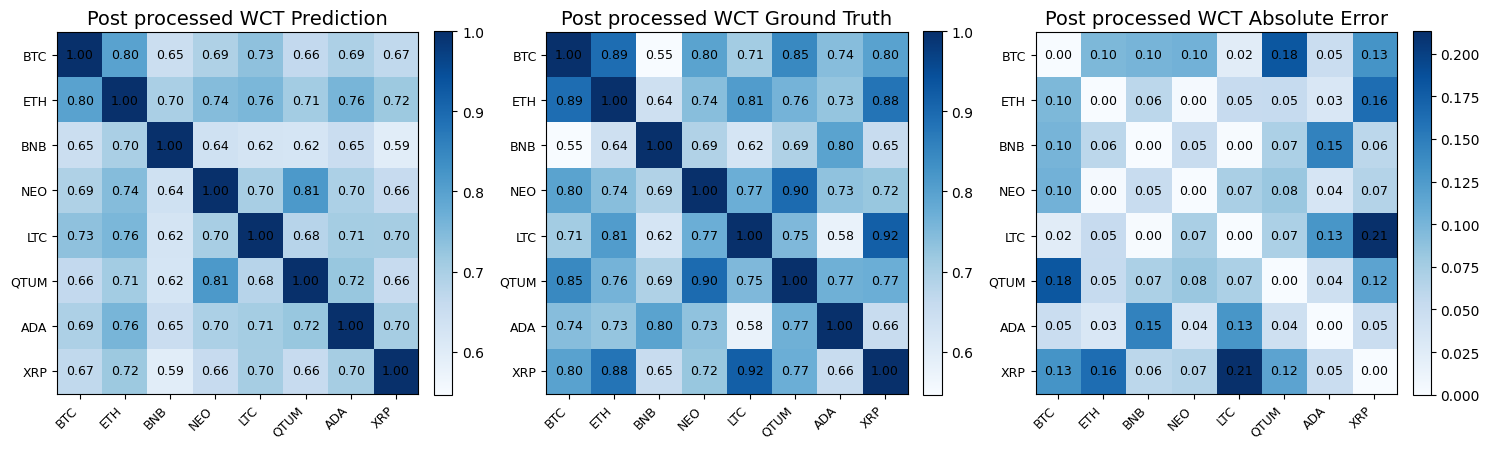

In [ ]:
# Correlation Matrix Comparison

preds_tensor = WCT_loaded['preds']
targets_tensor = WCT_loaded['targets']

post_preds = []
for t in range(preds_tensor.size(0)):
    y_pred = preds_tensor[t].cpu().numpy()
    y_pred_sym = 0.5 * (y_pred + y_pred.T)
    y_pred_sym_near = nearcorr(y_pred_sym)
    post_preds.append(y_pred_sym_near)

post_preds = np.stack(post_preds, axis=0)
post_preds_tensor = torch.from_numpy(post_preds)

idx = 3
pred_mat = post_preds_tensor[idx].cpu().numpy()
true_mat = targets_tensor[idx].cpu().numpy()
error_mat = np.abs(pred_mat - true_mat)

common_min = min(pred_mat.min(), true_mat.min())
common_max = max(pred_mat.max(), true_mat.max())
error_max = error_mat.max()

titles = ["Prediction", "Ground Truth", "Absolute Error"]
matrices = [pred_mat, true_mat, error_mat]
cmap = "Blues"
vmins = [common_min, common_min, 0]
vmaxs = [common_max, common_max, error_max]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, mat, title, vmin, vmax in zip(axes, matrices, titles, vmins, vmaxs):
    im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(f'Post processed WCT {title}', fontsize=14)

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, f"{mat[i, j]:.2f}", ha="center", va="center",
                    color="black", fontsize=9)

    ax.set_xticks(range(len(symbols)))
    ax.set_yticks(range(len(symbols)))
    ax.set_xticklabels(symbols, rotation=45, ha="right", fontsize=9)
    ax.set_yticklabels(symbols, fontsize=9)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/WaveletFrequencyDecomposed_CNN_Transformer/figure/wct_sample_visualization_with_symbols.png', dpi=200)
plt.show()

# Correlation Matrix Comparison
preds_tensor = DCC_GARCH_loaded['preds']
targets_tensor = DCC_GARCH_loaded['targets']

idx = 3
pred_mat = preds_tensor[idx].cpu().numpy()
true_mat = targets_tensor[idx].cpu().numpy()
error_mat = np.abs(pred_mat - true_mat)

common_min = min(pred_mat.min(), true_mat.min())
common_max = max(pred_mat.max(), true_mat.max())
error_max = error_mat.max()

titles = ["Prediction", "Ground Truth", "Absolute Error"]
matrices = [pred_mat, true_mat, error_mat]
cmap = "Blues"
vmins = [common_min, common_min, 0]
vmaxs = [common_max, common_max, error_max]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, mat, title, vmin, vmax in zip(axes, matrices, titles, vmins, vmaxs):
    im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(f'DCC-GARCH {title}', fontsize=14)

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, f"{mat[i, j]:.2f}", ha="center", va="center",
                    color="black", fontsize=9)

    ax.set_xticks(range(len(symbols)))
    ax.set_yticks(range(len(symbols)))
    ax.set_xticklabels(symbols, rotation=45, ha="right", fontsize=9)
    ax.set_yticklabels(symbols, fontsize=9)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/WaveletFrequencyDecomposed_CNN_Transformer/figure/dcc-garch_sample_visualization_with_symbols.png', dpi=200)
plt.show()



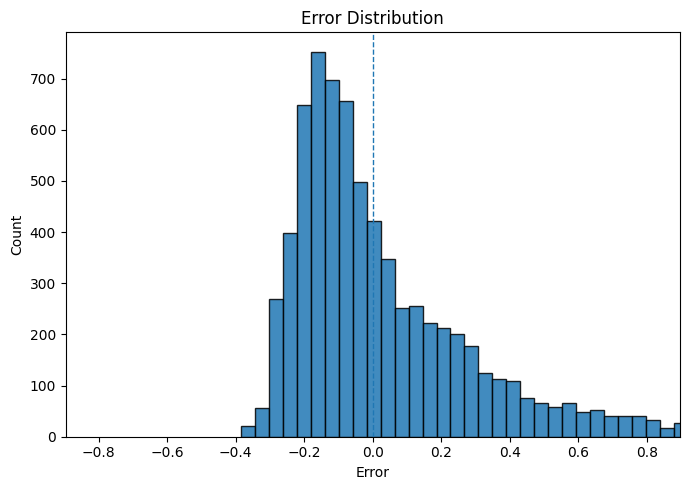

In [ ]:
# Error Distribution

preds_tensor = WCT_loaded['preds']
targets_tensor = WCT_loaded['targets']

post_preds = []
for t in range(preds_tensor.size(0)):
    y_pred = preds_tensor[t].cpu().numpy()
    y_pred_sym = 0.5 * (y_pred + y_pred.T)
    y_pred_sym_near = nearcorr(y_pred_sym)
    post_preds.append(y_pred_sym_near)

post_preds = np.stack(post_preds, axis=0)
post_preds_tensor = torch.from_numpy(post_preds)

assets = ['BTC', 'ETH', 'BNB', 'NEO', 'LTC', 'QTUM', 'ADA', 'XRP']

T, N, N2 = post_preds_tensor.shape

err = (post_preds_tensor - targets_tensor).detach().cpu().numpy()

tri_i, tri_j = np.triu_indices(N, k=1)
err_pairs = err[:, tri_i, tri_j]
err_flat = err_pairs.reshape(-1)

p_lo, p_hi = np.percentile(err_flat, [1, 99])
x_abs_max = float(max(abs(p_lo), abs(p_hi)))

plt.figure(figsize=(7,5))
plt.hist(err_flat, bins=40, alpha=0.85, edgecolor='black')
plt.axvline(0, ls='--', lw=1)
plt.title("Error Distribution")
plt.xlabel("Error")
plt.ylabel("Count")
plt.xlim(-x_abs_max, x_abs_max)
plt.tight_layout()
# plt.savefig(os.path.join("/content/drive/MyDrive/WaveletFrequencyDecomposed_CNN_Transformer/figure/Error Distribution.png"), dpi=180)
plt.show()
plt.close()

In [ ]:
# DM Test

def diebold_mariano_from_losses(loss_a, loss_b, lag=0):
    d = np.asarray(loss_a) - np.asarray(loss_b)
    Tn = d.shape[0]
    d_bar = d.mean()
    gamma0 = np.var(d, ddof=1)
    if lag == 0:
        var_d = gamma0
    else:
        var_d = gamma0
        for k in range(1, lag+1):
            w = 1.0 - k/(lag+1)
            cov = np.cov(d[k:], d[:-k], ddof=1)[0,1]
            var_d += 2.0 * w * cov
    DM = d_bar / np.sqrt(var_d / Tn)
    pval = 2 * (1 - t.cdf(abs(DM), df=Tn-1))
    DM = DM.round(3)
    pval = pval.round(3)
    return float(DM), float(pval)

def sym_nearcorr_stack(preds_tensor: torch.Tensor) -> np.ndarray:
    out = []
    for t in range(preds_tensor.size(0)):
        M = preds_tensor[t].detach().cpu().numpy()
        M = 0.5 * (M + M.T)
        M = nearcorr(M)
        out.append(M)
    return np.stack(out, axis=0)

def offdiag_losses_per_time(y_true_TNN, y_pred_TNN, kind="MSE"):
    T, N, _ = y_true_TNN.shape
    mask = ~np.eye(N, dtype=bool)
    yt = y_true_TNN[:, mask]  # (T, N*(N-1))
    yp = y_pred_TNN[:, mask]
    if kind.upper() == "MSE":
        return ((yp - yt) ** 2).mean(axis=1)
    else:  # MAE
        return np.abs(yp - yt).mean(axis=1)

def dm_table_against_wct(WCT_loaded, others_dict, lag=0, use_mae=True, use_mse=True):
    y_true = WCT_loaded['targets'].detach().cpu().numpy()
    y_pred_wct = sym_nearcorr_stack(WCT_loaded['preds'])
    rows = []
    for name, pack in others_dict.items():
        y_pred_b = sym_nearcorr_stack(pack['preds'])
        Tm = min(len(y_true), len(y_pred_wct), len(y_pred_b))
        yt = y_true[:Tm]; pw = y_pred_wct[:Tm]; pb = y_pred_b[:Tm]

        row = {'Baseline': name}
        if use_mse:
            wct_mse  = offdiag_losses_per_time(yt, pw, "MSE")
            base_mse = offdiag_losses_per_time(yt, pb, "MSE")
            DM_mse, p_mse = diebold_mariano_from_losses(wct_mse, base_mse, lag=lag)
            row.update({'DM (MSE)': round(DM_mse,4), 'p-value (MSE)': p_mse})
        if use_mae:
            wct_mae  = offdiag_losses_per_time(yt, pw, "MAE")
            base_mae = offdiag_losses_per_time(yt, pb, "MAE")
            DM_mae, p_mae = diebold_mariano_from_losses(wct_mae, base_mae, lag=lag)
            row.update({'DM (MAE)': round(DM_mae,4), 'p-value (MAE)': p_mae})
        rows.append(row)
    return pd.DataFrame(rows)

others = {
    'WC': WC_loaded,
    'WT': WT_loaded,
    'CT': CT_loaded,
    'DCC-GARCH': DCC_GARCH_loaded,
}
dm_results = dm_table_against_wct(WCT_loaded, others)
print(dm_results.to_markdown(index=False))


| Baseline   |   DM (MSE) |   p-value (MSE) |   DM (MAE) |   p-value (MAE) |
|:-----------|-----------:|----------------:|-----------:|----------------:|
| WC         |     -2.221 |           0.027 |     -2.445 |           0.015 |
| WT         |     -2.114 |           0.036 |     -0.405 |           0.686 |
| CT         |      0.605 |           0.546 |     -6.973 |           0     |
| DCC-GARCH  |     -3.279 |           0.001 |     -6.979 |           0     |


In [ ]:
        WC         & -2.2211 & 0.0272 & -2.4452 & 0.0152 \\
        WT         & -2.1138 & 0.0355 & -0.4050 & 0.6858 \\
        CT         &  0.6047 & 0.5459 & -6.9727 & 2.74$\times10^{-11}$ \\
        DCC-GARCH  & -3.2794 & 0.0012 & -6.9787 & 2.64$\times10^{-11}$ \\